# Task: Variational Autoencoder
Building VAE for FashionMNIST image dataset

## Imports

In [92]:
import os
from pathlib import Path
import fastprogress
import time

from fastprogress import progress_bar, master_bar
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

torch.set_float32_matmul_precision('high')

### Helper functions

In [93]:
def get_mean_std(dataloader):

    mean = 0.0
    std = 0.0
    for images, _ in dataloader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(dataloader.dataset)
    std /= len(dataloader.dataset)

    return mean, std


def get_device(cuda_id=0):
    use_cuda = torch.cuda.is_available()
    device = torch.device(f'cuda:{cuda_id}' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device


def load_fmnist(path, train, transform=torchvision.transforms.ToTensor()):
    return torchvision.datasets.FashionMNIST(path, train=train, download=True, transform=transform)


def get_dataLoader(data, batch_size=128, shuffle=False, num_workers=2, collate_fn=None):
    return torch.utils.data.DataLoader(data,batch_size=batch_size,
                                       shuffle=shuffle,num_workers=num_workers,collate_fn=collate_fn)


def show_images(loader, title='', feature_names=None):
    """show 6 images from dataloader"""
    plt.close('all')
    sns.set_theme(
        style='whitegrid',
        rc={'figure.figsize': (12, 5), 'font.size': 14}
    )

    x, y = next(iter(loader))
    idx = np.random.randint(0, x.shape[0], 12)
    fig, ax = plt.subplots(2, 6)
    fig.suptitle(title)

    for axs, i in zip(ax.flatten(), idx):
        if x.shape[1] == 3:
            axs.imshow(x[i].permute(1,2,0))
        else:
            axs.imshow(x[i].permute(1,2,0), cmap='gray')
        axs.axis(False)
        class_name = y[i].item()
        if feature_names is not None:
            class_name = feature_names[class_name]
        axs.set_title(f"{class_name}")

    plt.show()
    

def show_grid(images_tensor, images_columns, images_rows):
    image = torchvision.utils.make_grid(images_tensor, images_columns, images_rows)
    image = image.numpy()
    fig = plt.gcf()
    plt.axis('off')
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

### CUDA Check

In [94]:
device = get_device(0)

Using device NVIDIA A100 80GB PCIe


### Paths

In [95]:
path = Path().cwd()

data_folder = path / 'data'
data_folder.mkdir(exist_ok=True)

checkpoint_folder = path / 'checkpoint'
checkpoint_folder.mkdir(exist_ok=True)

data_folder, checkpoint_folder

(PosixPath('/home/ah19/Course Assignments/data'),
 PosixPath('/home/ah19/Course Assignments/checkpoint'))

### Load & normalize data


In [96]:
# load train data
traindata = load_fmnist(data_folder, train=True)
trainloader = get_dataLoader(traindata)

### Sample Images

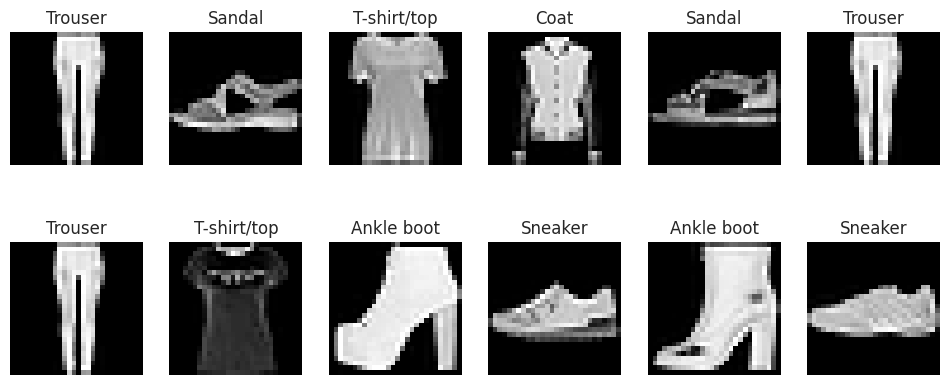

In [97]:
# classes
classes = ["T-shirt/top","Trouser","Pullover","Dress",
           "Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]


show_images(trainloader, feature_names=classes)

### VAE Model

In [98]:
class VAE(nn.Module):
    def __init__(self, latent_dims):
        super(VAE, self).__init__()
        self.encoder = torch.nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=(4, 4), stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(32, 2*32, kernel_size=(4, 4), stride=2, padding=1),
                nn.ReLU()
        )

        self.decoder = torch.nn.Sequential(
                nn.ConvTranspose2d(2*32, 32, kernel_size=(4, 4), stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=2, padding=1),
                nn.Sigmoid()
        )

        self.mu = nn.Linear(2*32*7*7, latent_dims)
        self.logvar = nn.Linear(2*32*7*7, latent_dims)
        self.z = nn.Linear(latent_dims, 2*32*7*7)
        
    def decode(self, sample):
        z = self.z(sample)        
        z = z.unflatten(1, (2*32, 7, 7))
        return self.decoder(z)
    
    def encode(self, x):
        x_enc = self.encoder(x)
        x_enc = torch.flatten(x_enc, start_dim=1)
        mu, logvar = self.mu(x_enc), self.logvar(x_enc)
        x = self.reparametrize(mu, logvar)
        return x, mu, logvar

    def reparametrize(self, mu, logvar):
        std = torch.exp(logvar/2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        eps = p.sample()
        return mu + std*eps

    def sample(self, x=None):
        x, mu, logvar = self.encode(x)
        return x, mu, logvar
    
    def forward(self, x):
        x, mu, logvar = self.sample(x)
        recon_x = self.decode(x)
        return recon_x, mu, logvar

### Cost Function

In [99]:
def vae_loss(recon_x, x, mu, logvar):
    # mean square error loss
    mse_loss = ((x - recon_x)**2).sum()/(x.shape[0])

    # kl loss
    std = torch.exp(logvar / 2)                         
    kld_loss = (-1/2 + std**2 + mu**2 - logvar).sum()/(std.shape[0])
    
    # total loss
    total_loss = mse_loss + kld_loss

    return total_loss, mse_loss, kld_loss

### Initaite model

In [100]:
# Dimension of the latent space
latent_space_dim = 2

model = VAE(latent_space_dim).to(device)
model = torch.compile(model)

### Optimizer and learning scheduler

In [101]:
lr = 1e-2
epochs = 20
batch_size = 64
patience = 3
optim_name = 'AdamW'
scheduler_name = 'ReduceLROnPlateau'

optimizer = getattr(torch.optim, optim_name)(model.parameters(), lr=lr)
scheduler = getattr(torch.optim.lr_scheduler, scheduler_name)(optimizer, mode='min', patience=patience, min_lr=1e-6)

### Dataloaders

In [102]:
trainloader = get_dataLoader(traindata, batch_size=batch_size, shuffle=True)

### Train and Test

In [103]:
total_losses = []
mse_losses = []
kld_losses = []

mb = master_bar(range(epochs))

for epoch in mb:

    model.train()
    
    for x, _ in progress_bar(trainloader, parent=mb):
        
        optimizer.zero_grad()
        
        mb.child.comment = "Training"
        
        # Move tensors to device
        x = x.to(device)

        # Forward pass
        recon_x, mu, logvar = model(x)
        
        # Calculate loss
        total_loss, mse_loss, kld_loss = vae_loss(recon_x, x, mu, logvar)
        
        
        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()
        
        total_losses.append(total_loss.item())
        mse_losses.append(mse_loss.item())
        kld_losses.append(kld_loss.item())
    
    # Step scheduler
    scheduler.step(total_loss.mean().item())
    
    # Print epoch information
    mb.write(f"Epoch [{epoch+1:03}], LR: {optimizer.param_groups[0]['lr']:.1e}, Loss: {sum(total_losses)/len(total_losses):.2f}, mse: {sum(mse_losses)/len(mse_losses):.2f}, kld: {sum(kld_losses)/len(kld_losses):.2f}")

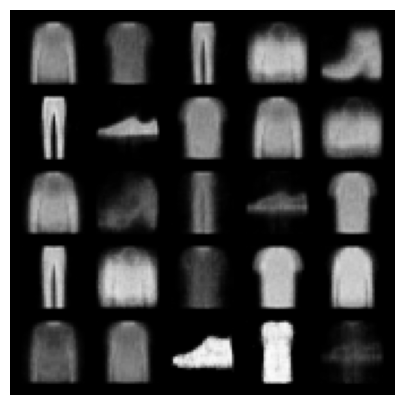

In [104]:
images_columns = 5
images_rows = 5

with torch.no_grad():
    samples = torch.randn(images_columns * images_rows, latent_space_dim).to(device)
    samples = model.decode(samples).cpu()

    show_grid(samples[0:(images_columns * images_rows)], images_columns, images_rows)

### Reconstructed Images

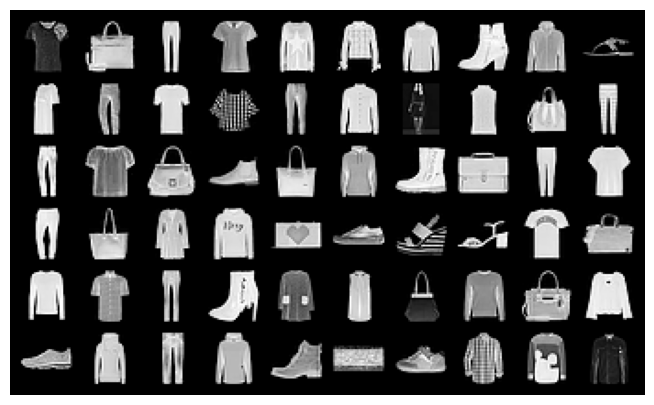

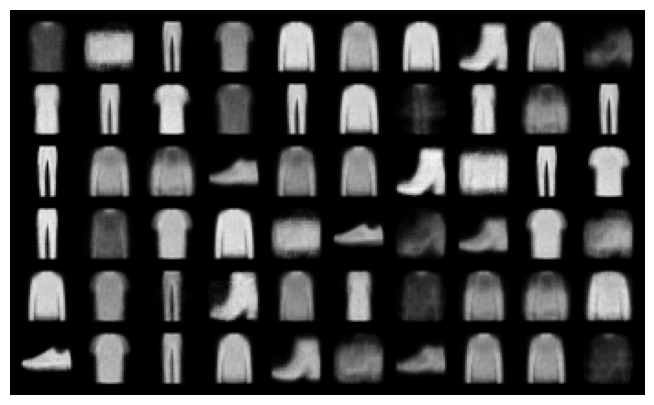

In [105]:
images_columns = 10
images_rows    = 6

data_iterator = iter(trainloader)
images, labels = next(data_iterator)

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():
    images_recon, _, _ = model(images.to(device))
    images_recon = images_recon.cpu()
    show_grid(images_recon[0:(images_columns * images_rows)], images_columns, images_rows)